<a href="https://colab.research.google.com/github/carlosmvond/modelos_predictivos/blob/main/MP_Clase_8oct2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


En este código vamos a calibrar una regresión no-lineal usando inferencia bayesiana.




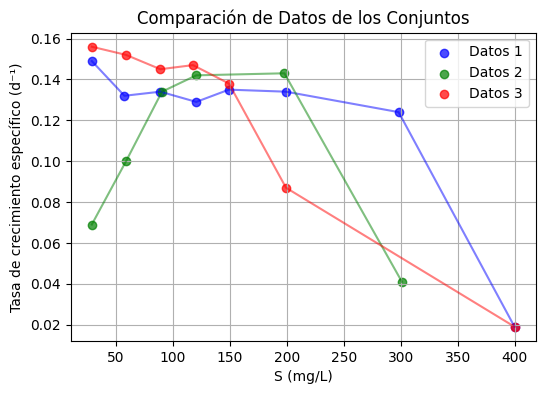

In [94]:

#DATOS

#!pip install pymc     # Para instalar PyMC!


import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd

# 1. Generar datos a partir de una regresión lineal y agregar error
np.random.seed(42)

# Data for the DataFrame
data1 = {
    'S': [28.674, 57.348, 88.889, 120.430, 149.104, 199.283, 298.208, 400.000],
    'mu': [0.149, 0.132, 0.134, 0.129, 0.135, 0.134, 0.124, 0.019]
}

data2 = {
    'S': [28.674, 58.781, 90.323, 120.430, 197.849, 301.075],
    'mu': [0.069, 0.100, 0.134, 0.142, 0.143, 0.041]
}

data3 = {
    'S': [28.674, 58.781, 88.889, 117.563, 149.104, 199.283, 400.000],
    'mu': [0.156, 0.152, 0.145, 0.147, 0.138, 0.087, 0.019]
}

# Create DataFrame
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)


# Create arrays
S_obs1 = df1['S'].to_numpy()
mu_obs1 = df1['mu'].to_numpy()

S_obs2 = df2['S'].to_numpy()
mu_obs2 = df2['mu'].to_numpy()

S_obs3 = df3['S'].to_numpy()
mu_obs3 = df3['mu'].to_numpy()

# Crear un gráfico
plt.figure(figsize=(6, 4))



# Plot each dataset with scatter and line connecting the points
plt.scatter(S_obs1, mu_obs1, color='blue', label='Datos 1', alpha=0.7)
plt.plot(S_obs1, mu_obs1, color='blue', alpha=0.5)  # Line connecting points

plt.scatter(S_obs2, mu_obs2, color='green', label='Datos 2', alpha=0.7)
plt.plot(S_obs2, mu_obs2, color='green', alpha=0.5)  # Line connecting points

plt.scatter(S_obs3, mu_obs3, color='red', label='Datos 3', alpha=0.7)
plt.plot(S_obs3, mu_obs3, color='red', alpha=0.5)  # Line connecting points

# Add labels and title
plt.xlabel('S (mg/L)')
plt.ylabel('Tasa de crecimiento específico (d⁻¹)')
plt.title('Comparación de Datos de los Conjuntos')
plt.legend()
plt.grid()

# Show the plot
plt.show()



Ahora ajustamos la regresión  utilizando PyMC.

In [96]:
#MODELO BAYESIANO

S_obs=S_obs1
mu_obs=mu_obs1

# 2. Ajustar una regresión lineal usando PyMC
with pm.Model() as model1:

    mumax=pm.Lognormal('mumax', mu=np.log(0.14), sigma=0.01)
    alpha=pm.Uniform('alpha', lower=0.001, upper=0.1 )
    Sopt=pm.Uniform('Sopt', lower=0.1, upper=300 )
    sigma = pm.HalfNormal('sigma', sigma=0.01)


    model = mumax*S_obs/(S_obs+(mumax/alpha)*(-1+S_obs/Sopt)**2)

    # Usar la distribución normal para las observaciones

    y_obs = pm.Normal('y_obs', mu=model, sigma=sigma, observed=mu_obs)
    #y_obs = pm.StudentT('y_obs', mu=model, sigma=sigma, nu=3, observed=mu_obs)
    trace_M1 = pm.sample(1000, tune=1000, return_inferencedata=True, chains=2, cores=2, target_accept=0.95)



with pm.Model() as model2:

    mumax=pm.Lognormal('mumax', mu=np.log(0.14), sigma=0.01)
    #alpha=pm.Uniform('alpha', lower=0.001, upper=0.01 )
    Sopt=pm.Uniform('Sopt', lower=0.1, upper=300 )
    sigma = pm.HalfNormal('sigma', sigma=0.01)


    model = mumax*(S_obs/Sopt)*np.exp(1-S_obs/Sopt)

    # Usar la distribución normal para las observaciones

    y_obs = pm.Normal('y_obs', mu=model, sigma=sigma, observed=mu_obs)
    #y_obs = pm.StudentT('y_obs', mu=model, sigma=sigma, nu=3, observed=mu_obs)
    trace_M2 = pm.sample(1000, tune=1000, return_inferencedata=True, chains=2, cores=2, target_accept=0.95)



Output()

Output()

<ipython-input-97-b91f71043d2a>:64: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=hdi_prob)  # HDI of predictions


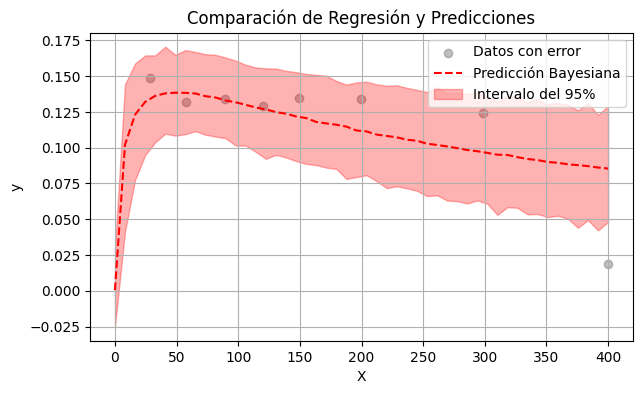

<ipython-input-97-b91f71043d2a>:64: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=hdi_prob)  # HDI of predictions


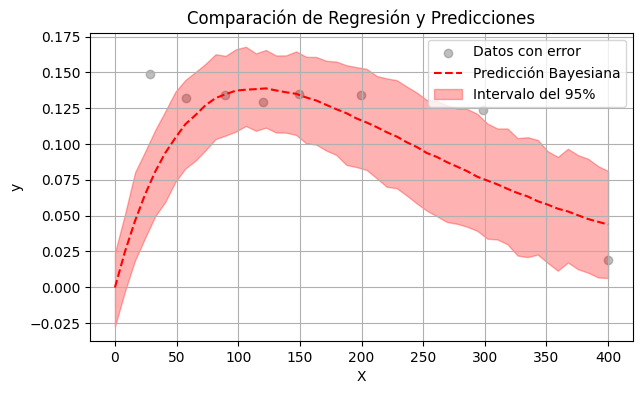

          mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Sopt   122.031  38.119    64.238    209.480      1.871    1.468     752.0   
alpha    0.008   0.002     0.005      0.010      0.000    0.000    1101.0   
mumax    0.140   0.001     0.137      0.142      0.000    0.000    1379.0   
sigma    0.013   0.005     0.005      0.022      0.000    0.000     942.0   

       ess_tail  r_hat  
Sopt      366.0    1.0  
alpha     788.0    1.0  
mumax    1299.0    1.0  
sigma    1072.0    1.0  


In [97]:
from scipy.stats import t


# HDI (Intervalo de Densidad Alta) para la regresión bayesiana
mumax_M1_samples = trace_M1.posterior['mumax'].values.flatten()
alpha_M1_samples = trace_M1.posterior['alpha'].values.flatten()
Sopt_M1_samples = trace_M1.posterior['Sopt'].values.flatten()
sigma_M1_samples = trace_M1.posterior['sigma'].values.flatten()

mumax_M2_samples = trace_M2.posterior['mumax'].values.flatten()
Sopt_M2_samples = trace_M2.posterior['Sopt'].values.flatten()
sigma_M2_samples = trace_M2.posterior['sigma'].values.flatten()



#GRÁFICOS

def evaluate_M1(S, mumax, alpha, Sopt):

  mu_values = mumax * S / (S + (mumax / alpha) * (-1 + S / Sopt)**2)
  return mu_values

def evaluate_M2(S, mumax,Sopt):

  mu_values = mumax*(S/Sopt)*np.exp(1-S/Sopt)
  return mu_values

# 3. Crear gráficos

S_plot=np.linspace(0, 400, 50)

y_M1_pred_samples = np.empty((len(mumax_M1_samples), len(S_plot)))
y_M2_pred_samples = np.empty((len(mumax_M2_samples), len(S_plot)))


for i in range(len(mumax_samples)):
    # Calcular el parámetro de ubicación (mu) para la muestra actual
    mu1 = evaluate_M1(S_plot, mumax_M1_samples[i], alpha_M1_samples[i], Sopt_M1_samples[i])
    mu2 = evaluate_M2(S_plot, mumax_M2_samples[i], Sopt_M2_samples[i])
    # Generar predicciones usando la distribución normal
    for j in range(len(S_plot)):
        y_M1_pred_samples[i,j] = np.random.normal(loc=mu1[j], scale=sigma_samples[i])
        y_M2_pred_samples[i,j] = np.random.normal(loc=mu2[j], scale=sigma_samples[i])

        #y_pred_samples[i,j] = np.random.normal(loc=mu[j], scale=sigma_samples[i])
        #y_pred_samples[i,j]= t.rvs(df=3, loc=mu[j], scale=sigma_samples[i])




def plot_predictions(S_obs, mu_obs, S_plot, y_pred_samples, hdi_prob=0.95):
    """
    Plots the predictions from a Bayesian regression model along with the original data points.

    Args:
        S_obs: Array of observed substrate concentrations.
        mu_obs: Array of observed growth rates.
        S_plot: Array of substrate concentrations for predictions.
        y_pred_samples: Samples of predicted growth rates.
        hdi_prob: Probability for the highest density interval (default is 0.95).
    """
    # Calculate mean and highest density intervals for predictions
    y_pred_mean = y_pred_samples.mean(axis=0)  # Mean of predicted samples
    y_pred_hdi = az.hdi(y_pred_samples, hdi_prob=hdi_prob)  # HDI of predictions

    # Create the plot
    plt.figure(figsize=(7, 4))

    # Plot original data with errors
    plt.scatter(S_obs, mu_obs, label='Datos con error', color='gray', alpha=0.5)

    # Bayesian regression line (mean prediction)
    plt.plot(S_plot, y_pred_mean, label='Predicción Bayesiana', color='red', linestyle='--')

    # Credible intervals for Bayesian predictions
    plt.fill_between(S_plot, y_pred_hdi[:, 0], y_pred_hdi[:, 1], color='red', alpha=0.3, label='Intervalo del 95%')

    # Details for the plot
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Comparación de Regresión y Predicciones')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()


plot_predictions(S_obs, mu_obs, S_plot, y_M1_pred_samples, hdi_prob=0.95)
plot_predictions(S_obs, mu_obs, S_plot, y_M2_pred_samples, hdi_prob=0.95)



# 5. Summary of the predictions
summary = az.summary(trace, hdi_prob=0.95)
print(summary)





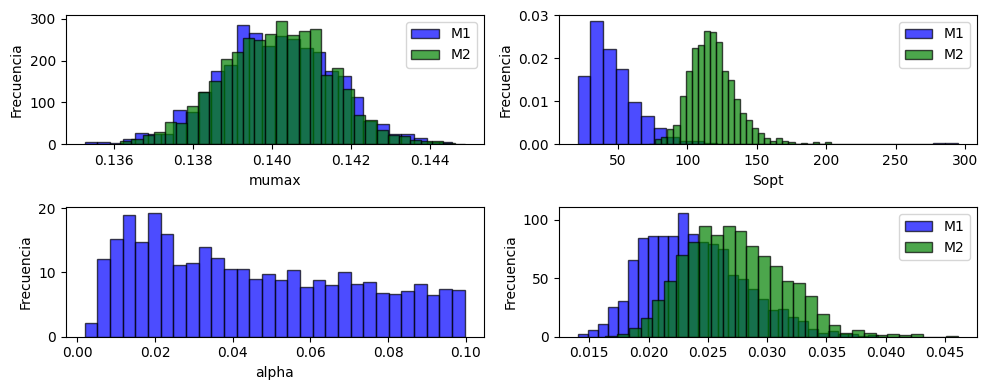

In [98]:
#HISTOGRAMAS M1

# 6. Crear histogramas para los parámetros
plt.figure(figsize=(10, 4))

# Histograma de alpha
plt.subplot(2, 2, 1)
plt.hist(mumax_M1_samples, bins=30, color='blue', edgecolor='k', alpha=0.7, density=True, label='M1')  # M1 is blue
plt.hist(mumax_M2_samples, bins=30, color='green', edgecolor='k', alpha=0.7, density=True, label='M2')  # M2 is green
plt.legend(loc='upper right')

plt.xlabel('mumax')
plt.ylabel('Frecuencia')

# Histograma de beta
plt.subplot(2, 2, 2)
plt.hist(Sopt_M1_samples, bins=30, color='blue', edgecolor='k', alpha=0.7, density=True,  label='M1')
plt.hist(Sopt_M2_samples, bins=30, color='green', edgecolor='k', alpha=0.7, density=True,  label='M2')
plt.legend(loc='upper right')

plt.xlabel('Sopt')
plt.ylabel('Frecuencia')

# Histograma de sigma
plt.subplot(2, 2, 3)
plt.hist(alpha_M1_samples, bins=30, color='blue', edgecolor='k', alpha=0.7, density=True)
plt.xlabel('alpha')
plt.ylabel('Frecuencia')

# Histograma de sigma
plt.subplot(2, 2, 4)
plt.hist(sigma_M1_samples, bins=30, color='blue', edgecolor='k', alpha=0.7, density=True,label='M1' )
plt.hist(sigma_M2_samples, bins=30, color='green', edgecolor='k', alpha=0.7, density=True,label='M2' )

plt.legend(loc='upper right')
plt.xlabel('')
plt.ylabel('Frecuencia')

# Ajustar el diseño de los subgráficos
plt.tight_layout()

# Mostrar los histogramas
plt.show()

In [105]:
#az.summary(trace)
#pm.model_to_graphviz(model)
#az.plot_pair(trace)
#az.plot_posterior(trace)
#az.plot_trace(trace)
# Compute Bayes Factor
# Access the log_likelihood data correctly
# Compute log-likelihood manually for both models

# Estimate LOO
with model1:
    pm.compute_log_likelihood(trace_M1)

loo_M1 = az.loo(trace_M1)


with model2:
    pm.compute_log_likelihood(trace_M2)

loo_M2 = az.loo(trace_M2)


df_comp_loo = az.compare({"M1": trace_M1, "M2": trace_M2})
df_comp_loo

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
M1,0,12.562750,5.341531,0.000000,0.666039,6.529680,0.00000,True,log
M2,1,11.553521,4.128607,1.009228,0.333961,5.138582,8.28337,True,log
